In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random
import time

In [3]:
from experiencereplay import ExperienceReplay, PrioritizedExperienceReplay
from experiment import Experiment
from ddpg import DDPG
import nn
from exploration import EpsilonGreedyStrategy, OUStrategy

In [4]:
settings = dict(
    environment = 'Pendulum-v0',
    timesteps = 4000,
    max_replay_buffer_size = 100000,
    batch_size = 256,
    learning_start = 256,
    discount_factor = 0.9,

    actor_learning_rate=0.0001,
    q_learning_rate=0.001,
    
    actor_l2=None,
    q_l2=None,
    
    actor_target_approach_rate=0.99,
    q_target_approach_rate=0.99,
    
    train_updates_per_step = 10,
    priority_updates_per_step = 100,
    
    actor_net_layers = [256, 128],
    actor_net_activation_fn = tf.nn.elu,
    actor_bounded_output = True,
    q_net_layers =  [128],
    q_net_embedding = 128,
    q_net_activation_fn = tf.nn.elu,
 
    environment_seed = 0,
    noise_seed= 0,
    
    gpu_memory_fraction = 0.1,
    
    render_environment = True,
    render_frequency = 10,
    render_start = 3500,
)

settings["experiment_path"] = "experiments/experiment_ddpg_{}_{}".format(settings["environment"], int(time.time()))
settings["actor_tf_optimizer"] = tf_optimizer = tf.train.AdamOptimizer(settings["actor_learning_rate"])
settings["q_tf_optimizer"] = tf_optimizer = tf.train.AdamOptimizer(settings["q_learning_rate"])

In [5]:
def preprocess_state(observation):
    state = np.array(observation)
    if settings["environment"] == "MountainCarContinuous-v0":
        state[1] = state[1] * 10
        return state
    else:
        return state
    
def preprocess_reward(reward):
    if settings["environment"] == "MountainCarContinuous-v0":
        return reward * 0.01
    else:
        return reward

In [6]:
env = gym.make(settings["environment"])
env.seed(settings["environment_seed"])

observation = preprocess_state(env.reset())
state = observation

[2017-05-21 23:22:36,622] Making new env: Pendulum-v0


In [7]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

3
1
[ 1.  1.  8.]
[-1. -1. -8.]
[ 2.]
[-2.]


In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=settings["gpu_memory_fraction"])
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:
actor_network = nn.fully_connected("Actor", session, [state_dim], settings["actor_net_layers"],
                                   action_dim, settings["actor_net_activation_fn"],
                                   env.action_space if settings["actor_bounded_output"] else None, False)
q_network = nn.fully_connected_with_input_embedding(
    "Q", session, [state_dim, action_dim], settings["q_net_embedding"], settings["q_net_layers"], 1,
                               settings["q_net_activation_fn"], None, False)

print(str(actor_network))

[] --> Actor_input_0
['Actor_input_0'] --> hidden_0_256
['hidden_0_256'] --> hidden_1_128
['hidden_1_128'] --> output
['output'] --> bounding



In [10]:
agent = DDPG(actor_network, q_network,
             discount_factor=settings["discount_factor"],
             actor_tf_optimizer=settings["actor_tf_optimizer"],
             q_tf_optimizer=settings["q_tf_optimizer"],
             actor_l2=settings["actor_l2"],
             q_l2=settings["q_l2"],
             actor_target_approach_rate=settings["actor_target_approach_rate"],
             q_target_approach_rate=settings["q_target_approach_rate"]
            )

In [11]:
experience_replay = PrioritizedExperienceReplay(agent, env, settings["max_replay_buffer_size"], False)

In [12]:
exploration_strategy = EpsilonGreedyStrategy(agent, env, settings["noise_seed"])

In [13]:
exp = Experiment(settings["experiment_path"], session, env, settings, settings["render_environment"], settings["render_frequency"], settings["render_start"])

progress_bar = tqdm(total=settings["timesteps"])

for t in xrange(settings["timesteps"]):   
    exploration = ((settings["timesteps"] - t) / float(settings["timesteps"])) ** 4
    if t < settings["learning_start"]:
        exploration = 1

    action = exploration_strategy.action(state, exploration)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(preprocess_state(observation), (state_dim,))
    
    if exp.reward_100ma.get_average() > -0.1 and exp.episode_duration >= 100:
        exp.reward_100ma.reset()
        done = True
    
    experience_replay.add_experience(state, action, preprocess_reward(reward), next_state, done)
    td_error = math.fabs(experience_replay.get_last_td_error())
    exp.record(t, state, action, reward, next_state, done, td_error)
    
    state = next_state
    
    if done:
        exp.print_last_episode_info()
        observation = env.reset()
        state = preprocess_state(observation)
        
    if t >= settings["learning_start"]:
        experience_replay.train_agent(settings["batch_size"], settings["train_updates_per_step"])
        experience_replay.update_oldest_priorities(settings["priority_updates_per_step"])
            
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, Exploration: {:.2f}, action: {}, td-error: {:.4f}' \
        .format(t, reward, exp.reward_100ma.get_average(), exploration, str(action), td_error))
    progress_bar.update()
    
        
progress_bar.close()

[1435] reward: -0.72, reward 100-step MA: -0.01, Exploration: 0.17, action: [-2.], td-error: 0.0000:  36%|███▌      | 1436/4000 [01:51<04:07, 10.35it/s]         | 1/4000 [00:00<20:46,  3.21it/s]

Total episode reward: -8226.80643325. Finished in 1435 steps.


[1595] reward: -6.25, reward 100-step MA: -0.06, Exploration: 0.13, action: [ 1.08452916], td-error: 0.2675:  40%|███▉      | 1596/4000 [02:07<03:52, 10.33it/s]     : -0.88, reward 100-step MA: -0.04, Exploration: 0.17, action: [-1.89823723], td-error: 0.1890:  36%|███▌      | 1440/4000 [01:52<04:05, 10.42it/s]

Total episode reward: -256.861952677. Finished in 160 steps.


[1735] reward: -0.00, reward 100-step MA: -0.00, Exploration: 0.10, action: [ 0.22459596], td-error: 0.0000:  43%|████▎     | 1736/4000 [02:20<03:38, 10.37it/s] 1599] reward: -6.73, reward 100-step MA: -0.32, Exploration: 0.13, action: [-1.62731051], td-error: 0.0000:  40%|████      | 1600/4000 [02:07<03:51, 10.38it/s]

Total episode reward: -263.8297128. Finished in 141 steps.


[1863] reward: -7.65, reward 100-step MA: -0.08, Exploration: 0.08, action: [ 0.37197751], td-error: 0.0000:  47%|████▋     | 1864/4000 [02:33<03:26, 10.35it/s] 1739] reward: -0.46, reward 100-step MA: -0.02, Exploration: 0.10, action: [-1.56952918], td-error: 1.2981:  44%|████▎     | 1740/4000 [02:21<03:36, 10.42it/s]

Total episode reward: -129.013232911. Finished in 127 steps.


[2029] reward: -8.44, reward 100-step MA: -0.08, Exploration: 0.06, action: [ 2.], td-error: 0.5105:  51%|█████     | 2030/4000 [02:49<03:11, 10.30it/s]         1867] reward: -8.59, reward 100-step MA: -0.40, Exploration: 0.08, action: [-1.76676381], td-error: 0.0000:  47%|████▋     | 1868/4000 [02:33<03:25, 10.36it/s]

Total episode reward: -394.722244656. Finished in 166 steps.


[2213] reward: -0.06, reward 100-step MA: -0.00, Exploration: 0.04, action: [ 1.91606069], td-error: 0.0000:  55%|█████▌    | 2214/4000 [03:06<02:56, 10.14it/s] 2033] reward: -7.22, reward 100-step MA: -0.39, Exploration: 0.06, action: [ 1.98056054], td-error: 0.6367:  51%|█████     | 2034/4000 [02:49<03:09, 10.35it/s]

Total episode reward: -466.202745731. Finished in 184 steps.


[2313] reward: -0.01, reward 100-step MA: -0.00, Exploration: 0.03, action: [-1.62057149], td-error: 0.0000:  58%|█████▊    | 2314/4000 [03:16<02:45, 10.18it/s][2217] reward: -0.05, reward 100-step MA: -0.00, Exploration: 0.04, action: [-0.38357228], td-error: 0.0000:  55%|█████▌    | 2218/4000 [03:07<02:54, 10.22it/s]

Total episode reward: -0.679593910063. Finished in 101 steps.


[2475] reward: -0.15, reward 100-step MA: -0.00, Exploration: 0.02, action: [ 2.], td-error: 0.0000:  62%|██████▏   | 2476/4000 [03:32<02:34,  9.90it/s]         2317] reward: -9.52, reward 100-step MA: -0.34, Exploration: 0.03, action: [ 2.], td-error: 0.3446:  58%|█████▊    | 2318/4000 [03:17<02:45, 10.14it/s]

Total episode reward: -377.271135441. Finished in 161 steps.


[2575] reward: -0.01, reward 100-step MA: -0.00, Exploration: 0.02, action: [ 2.], td-error: 0.0000:  64%|██████▍   | 2576/4000 [03:42<02:23,  9.93it/s]        [2479] reward: -0.05, reward 100-step MA: -0.01, Exploration: 0.02, action: [-0.02235568], td-error: 0.0000:  62%|██████▏   | 2480/4000 [03:33<02:30, 10.10it/s]

Total episode reward: -1.24576439359. Finished in 101 steps.


[2729] reward: -3.23, reward 100-step MA: -0.03, Exploration: 0.01, action: [-1.65990257], td-error: 0.0000:  68%|██████▊   | 2730/4000 [03:57<02:03, 10.26it/s] 579] reward: -7.58, reward 100-step MA: -0.32, Exploration: 0.02, action: [ 1.94697154], td-error: 0.2970:  64%|██████▍   | 2580/4000 [03:42<02:20, 10.10it/s]

Total episode reward: -346.408582049. Finished in 153 steps.


[2850] reward: -0.00, reward 100-step MA: -0.00, Exploration: 0.01, action: [ 0.86981618], td-error: 0.0000:  71%|███████▏  | 2851/4000 [04:09<01:51, 10.30it/s] 2733] reward: -3.36, reward 100-step MA: -0.16, Exploration: 0.01, action: [-1.72752595], td-error: 0.0000:  68%|██████▊   | 2734/4000 [03:57<02:04, 10.14it/s]

Total episode reward: -134.790559379. Finished in 122 steps.


[2951] reward: -0.00, reward 100-step MA: -0.00, Exploration: 0.00, action: [-0.06073409], td-error: 0.0000:  74%|███████▍  | 2952/4000 [04:19<01:43, 10.08it/s][2854] reward: -0.18, reward 100-step MA: -0.01, Exploration: 0.01, action: [ 2.], td-error: 0.7065:  71%|███████▏  | 2855/4000 [04:09<01:52, 10.20it/s]

Total episode reward: -2.31354317179. Finished in 101 steps.


[3096] reward: -2.55, reward 100-step MA: -0.03, Exploration: 0.00, action: [-1.79324269], td-error: 0.3259:  77%|███████▋  | 3097/4000 [04:33<01:29, 10.12it/s] 2955] reward: -6.92, reward 100-step MA: -0.24, Exploration: 0.00, action: [ 1.67555666], td-error: 0.2448:  74%|███████▍  | 2956/4000 [04:19<01:42, 10.21it/s]

Total episode reward: -251.240980277. Finished in 144 steps.


[3216] reward: -0.00, reward 100-step MA: -0.08, Exploration: 0.00, action: [-0.34413767], td-error: 0.0000:  80%|████████  | 3217/4000 [04:45<01:16, 10.23it/s][3100] reward: -2.99, reward 100-step MA: -0.13, Exploration: 0.00, action: [-1.63164282], td-error: 0.0000:  78%|███████▊  | 3101/4000 [04:33<01:28, 10.14it/s]

Total episode reward: -131.774528854. Finished in 122 steps.


[3318] reward: -0.00, reward 100-step MA: -0.00, Exploration: 0.00, action: [ 1.29666018], td-error: 0.0000:  83%|████████▎ | 3319/4000 [04:55<01:06, 10.17it/s][3220] reward: -0.01, reward 100-step MA: -0.00, Exploration: 0.00, action: [ 1.20537007], td-error: 0.0000:  81%|████████  | 3221/4000 [04:45<01:17, 10.04it/s]

Total episode reward: -0.262464451205. Finished in 101 steps.


[3439] reward: -0.00, reward 100-step MA: -0.09, Exploration: 0.00, action: [ 1.13709033], td-error: 0.0000:  86%|████████▌ | 3440/4000 [05:07<00:55, 10.15it/s][3322] reward: -2.02, reward 100-step MA: -0.07, Exploration: 0.00, action: [ 1.90731287], td-error: 0.3582:  83%|████████▎ | 3323/4000 [04:55<01:07, 10.10it/s]

Total episode reward: -128.877967011. Finished in 122 steps.


[3542] reward: -0.33, reward 100-step MA: -0.00, Exploration: 0.00, action: [ 2.], td-error: 0.0000:  89%|████████▊ | 3543/4000 [05:18<00:45,  9.96it/s]        [3443] reward: -0.04, reward 100-step MA: -0.00, Exploration: 0.00, action: [-1.82677627], td-error: 0.7489:  86%|████████▌ | 3444/4000 [05:07<00:55, 10.02it/s]

Total episode reward: -0.794406954628. Finished in 101 steps.


[3670] reward: -6.56, reward 100-step MA: -0.07, Exploration: 0.00, action: [-0.91683942], td-error: 0.0416:  92%|█████████▏| 3671/4000 [05:31<00:33,  9.97it/s] ward: -0.39, reward 100-step MA: -0.01, Exploration: 0.00, action: [ 2.], td-error: 0.0000:  89%|████████▊ | 3545/4000 [05:18<00:46,  9.81it/s]

Total episode reward: -129.253171385. Finished in 128 steps.


[3849] reward: -0.00, reward 100-step MA: -0.00, Exploration: 0.00, action: [ 1.30503345], td-error: 0.0393:  96%|█████████▋| 3850/4000 [05:48<00:14, 10.14it/s] 3674] reward: -7.40, reward 100-step MA: -0.34, Exploration: 0.00, action: [ 1.96057427], td-error: 0.0000:  92%|█████████▏| 3675/4000 [05:31<00:32, 10.11it/s]

Total episode reward: -393.294628039. Finished in 180 steps.


[3951] reward: -0.86, reward 100-step MA: -0.01, Exploration: 0.00, action: [ 2.], td-error: 0.1530:  99%|█████████▉| 3952/4000 [05:58<00:04, 10.04it/s]        [3853] reward: -0.00, reward 100-step MA: -0.00, Exploration: 0.00, action: [-0.98713779], td-error: 0.0000:  96%|█████████▋| 3854/4000 [05:49<00:14, 10.07it/s]

Total episode reward: -0.383064396993. Finished in 101 steps.


[3999] reward: -0.01, reward 100-step MA: -1.31, Exploration: 0.00, action: [ 1.62858033], td-error: 0.0000: 100%|██████████| 4000/4000 [06:03<00:00, 10.06it/s] ward: -0.70, reward 100-step MA: -0.04, Exploration: 0.00, action: [ 1.94709253], td-error: 0.1725:  99%|█████████▉| 3956/4000 [05:59<00:04, 10.12it/s]


In [14]:
exp.save()
print("Experiment results saved in " + exp.path)

Experiment results saved in experiments/experiment_ddpg_Pendulum-v0_1495401756


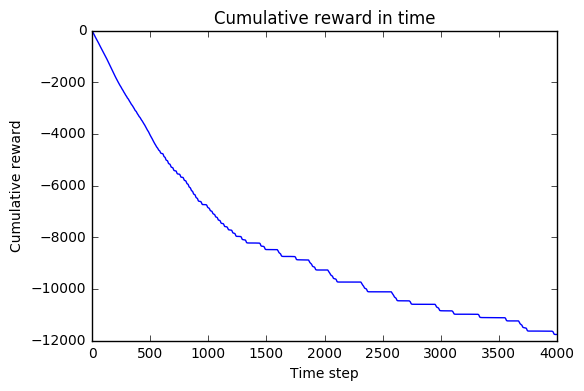

In [15]:
exp.plot_cumulative_reward()

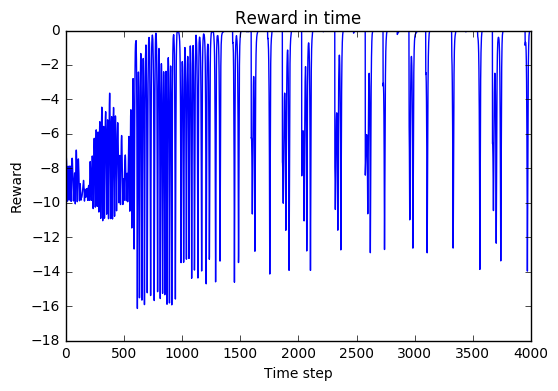

In [16]:
exp.plot_reward()

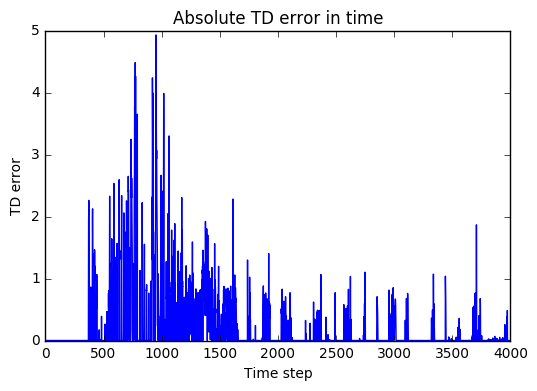

In [17]:
exp.plot_td_error()

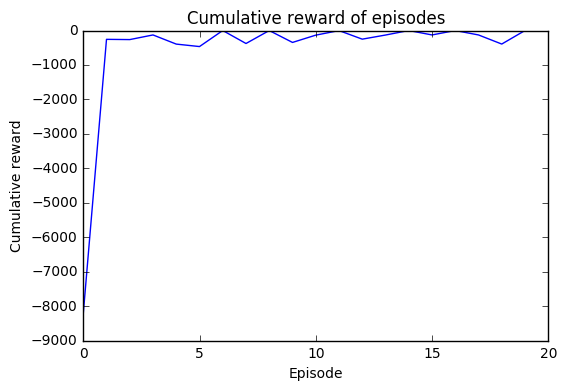

In [18]:
exp.plot_episode_reward()

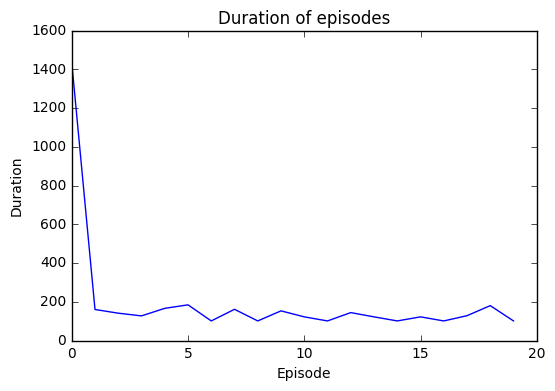

In [19]:
exp.plot_episode_duration()

In [20]:
#### if settings["render_environment"]:
    exp.display_frames_as_gif()

IndentationError: unexpected indent (<ipython-input-20-19429fee0595>, line 2)

In [ ]:
session.close()